In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np 
import time

#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install textacy

In [ ]:
import textacy.datasets
dataset = textacy.datasets.SupremeCourt()

In [ ]:
!python -m textacy download 'supreme_court'

In [ ]:
x_train=[]
y_train=[]
for text in dataset.records():
  x_train.append(text.text)
  y_train.append(text.meta['issue_area'])

In [ ]:
x_train[0]

In [ ]:
train_data = pd.DataFrame({'text': x_train, 'label': y_train, })
train_data.head()

In [ ]:
train_data.text.apply(lambda x:len(x.split())).plot(kind='hist')

In [ ]:
train_data.describe()

In [ ]:
train_data.shape

In [ ]:
train_data['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
#unbalanced dataset - distribution of datapoints is not the same for all the labels

In [ ]:
#remove the non-alphanumeric characters from the text 
import re 
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)     #() -- to match the sequence inside it , \-- to escape the special characters , 
                                     #\W -- get all the nonalphanumeric characters, + --all the instances 

  return text

In [ ]:
train_data['text']=train_data.text.apply(clean_txt)
train_data.head()

In [ ]:
#!pip install tensorflow==2.5.0

In [ ]:
#Installing the BERT module
!pip install bert-tensorflow
#!pip install bert-for-tf2

import bert
from bert import optimization

!pip install -q tf-models-official==2.4.0

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
print(tf.__version__)

# Setting the output Directory for BERT

In [ ]:
#Setting the output directory for BERT 
# Set the output directory for saving model file
OUTPUT_DIR = '/content/drive/MyDrive/Model_checkpoints_SC_512'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)#deletes everything under the directory recursively
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR) #Creates a directory and all parent/intermediate directories.
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

In [ ]:
print("Training Set Shape :", train_data.shape)

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())


# Splitting the Data into smaller chunks

In [ ]:
#Splitting the data into smaller chunks 
def get_split(text1):
  #l_total = text1--HETA
  l_total =[]
  l_parcial = []
  if len(text1.split())//450 >0:
    n = len(text1.split())//450
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:500]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*450:w*450 + 500] #overlapping 50 words in every chunks 
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
def get_split_count(text1):
  if len(text1.split())//450 >0:
    n = len(text1.split())//450
  else: 
    n = 1
  return n

In [ ]:
train_data['text_split'] = train_data[DATA_COLUMN].apply(get_split)
train_data.head()

In [ ]:
train_data['text_split_count'] = train_data[DATA_COLUMN].apply(get_split_count)
train_data.head()

In [ ]:
Dict_1 = {}
for i in train_data['text_split_count']:
  if i in Dict_1:
     Dict_1[i] = Dict_1[i] +1
  else:
     Dict_1[i] =1
  

In [ ]:
def fillin(chunk_count):
  if chunk_count in Dict_1:
    return Dict_1[chunk_count]

In [ ]:
train_data['data_count']= train_data['text_split_count'].apply(fillin)

In [ ]:
train_data

# Preprocessing the Train data 

In [ ]:
#remove the chunks which has only 1 example 
train_data_filtered = train_data[(train_data['text_split_count']<=20)]
#train_data_filtered = train_data_filtered[train_data_filtered['label'] !=14]
train_data_filtered.shape , train_data.shape

In [ ]:
train_data_filtered['label'].value_counts()

In [ ]:
train_data = train_data_filtered

In [ ]:
train_data.shape

In [ ]:
len(train_data)

In [ ]:
label_list = [x for x in np.unique(train_data.label)]
label_list

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_data, test_size=0.2, random_state=35)
train.head()

In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

In [ ]:
val.reset_index(drop=True, inplace=True)
val.head(2)

In [ ]:
train.shape, val.shape

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:  #it is going to create list of training chunks with label and index mapping 
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)
#HETA
# train_l = []
# label_l = []
# index_l =[]
# for idx,row in train.iterrows():
#     train_l.append(row['text_split'])
#     label_l.append(row['label'])
#     index_l.append(idx)
# len(train_l), len(label_l), len(index_l)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)
#HETA
# val_l = []
# val_label_l = []
# val_index_l = []
# for idx,row in val.iterrows():
#     val_l.append(row['text_split'])
#     val_label_l.append(row['label'])
#     val_index_l.append(idx)
# len(val_l), len(val_label_l), len(val_index_l)

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

In [ ]:
print('train_df shape : ',train_df.shape)
print('val_df shape : ',val_df.shape)

# BERT: Data Preprocessing

In [ ]:
class PaddingInputExample(object):
      pass

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
train_InputExamples_1 = train_df.apply(lambda x: InputExample(guid=None,
                                                                  text_a = x[DATA_COLUMN], 
                                                                  text_b = None, 
                                                                  label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples_1

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples_1.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples_1.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples_1.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples_1.iloc[0].label)

In [ ]:
val_InputExamples_1 = val_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# BERT: Loading the pre-trained model

In [ ]:
import official.nlp.bert.tokenization as tokenization

In [ ]:
# ##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
# #BERT: Loading the pre-trained model
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.compat.v1.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

In [ ]:
len(tokenizer.vocab.keys())

In [ ]:
#Defining Input features 
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[:128] + tokens_a[-(max_seq_length - 2 - 128):]

        tokens_a = tokens_a[0 : (max_seq_length - 2)]
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [ ]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=500):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels,features = [], [], [], [],[]
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )

        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

        feature = InputFeatures(input_ids=input_id,
        input_mask=input_mask,
        segment_ids=segment_id,
        label_id=label,
        is_real_example=True)

        features.append(feature)
    # return(
    #     np.array(input_ids),
    #     np.array(input_masks),
    #     np.array(segment_ids),
    #     np.array(labels).reshape(-1, 1),
    # )
    return features

In [ ]:
import tqdm
MAX_SEQ_LENGTH = 500

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.

train_features = convert_examples_to_features(tokenizer, train_InputExamples_1, MAX_SEQ_LENGTH)

val_features = convert_examples_to_features(tokenizer, val_InputExamples_1, MAX_SEQ_LENGTH)


In [ ]:
print("Sentence : ", train_InputExamples_1.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1]

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# # Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

In [ ]:
#Initializing the model and the estimator   <USE THIS BLOCK IF YOU ARE TRAINING FOR THE FIRST TIME>
# model_fn = model_fn_builder(
#   num_labels=len(label_list),
#   learning_rate=LEARNING_RATE,
#   num_train_steps=num_train_steps,
#   num_warmup_steps=num_warmup_steps)

# estimator = tf.estimator.Estimator(
#   model_fn=model_fn,
#   config=run_config,
#   params={"batch_size": BATCH_SIZE})

In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
import datetime

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
BATCH_SIZE

In [ ]:
# # #BERT: Fine Tuning Training & Evaluating
# # print(f'Beginning Training!')
# # #current_time = datetime.time()
#estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
# # #print("Training took time ", datetime.now() - current_time)

In [ ]:
# #Run this If you want to load the model 
# #Loading a specific check point : 
warm_start = tf.estimator.WarmStartSettings(ckpt_to_initialize_from='/content/drive/MyDrive/Model_checkpoints_SC_512/model.ckpt-2869.meta')


model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator=tf.estimator.Estimator(model_fn=model_fn,
                       config=run_config,
                       params={"batch_size": BATCH_SIZE},
                       warm_start_from=warm_start)

In [ ]:
#Evaluation of the BERT model
estimator.evaluate(input_fn=val_input_fn, steps=None)

# Extract Embeddings from BERT

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    number = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='number')
    receiver_tensors = {'number': number}
    features = tf.tile(number, multiples=[1, 2])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  #input_features = convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  input_features = convert_examples_to_features(tokenizer,input_examples,MAX_SEQ_LENGTH )
  #Predicting the classes 
  predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
MAX_SEQ_LENGTH

In [ ]:
train_df.shape, val_df.shape

In [ ]:
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))

In [ ]:
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

In [ ]:
 tr_emb.shape,val_emb.shape

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

In [ ]:
def finding_mean(mat):
    return np.mean(mat, axis=0)

In [ ]:
df_train['mean_emb'] = df_train['emb'].apply(finding_mean)

In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()


In [ ]:
df_val['mean_emb'] = df_val['emb'].apply(finding_mean)

In [ ]:
def new_get_split_count(mat):
  count = 0 
  for i in mat:
    count +=1 
  return count

In [ ]:
df_train['text_split_count'] = df_train['emb'].apply(new_get_split_count)

In [ ]:
df_train.shape

In [ ]:
df_test_1 = df_train[(df_train['text_split_count'].isin([4]))]
df_train_1 = df_train[~(df_train['text_split_count'].isin([4]))]

In [ ]:
df_train = df_train_1

In [ ]:
df_train.shape , df_test_1.shape

In [ ]:
df_val['text_split_count'] = df_val['emb'].apply(new_get_split_count)

In [ ]:
df_val.head(2)

In [ ]:
df_test_2 = df_val[(df_val['text_split_count'].isin([4]))]
df_val_1 = df_val[~(df_val['text_split_count'].isin([4]))]
df_val = df_val_1

In [ ]:
df_test_new = [df_test_1, df_test_2]
df_test_nw_1 = pd.concat(df_test_new)

In [ ]:
df_test = df_test_nw_1

In [ ]:
df_test.reset_index(drop=True, inplace=True)
df_test.head(2)

In [ ]:
df_train.shape , df_val.shape, df_test.shape

In [ ]:
len(df_train['label'].unique())

In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_train.head(2)

In [ ]:
df_val.reset_index(drop=True, inplace=True)
df_val.head(2)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

# LSTM Network Mean

In [ ]:
df_train

In [ ]:
df_train['label']=df_train['label'].replace([-1], 0)
df_test['label']=df_test['label'].replace([-1], 0)
df_val['label']=df_val['label'].replace([-1], 0)

In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 49   # 7*686
batches_per_epoch =  98
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 1201
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model_stack = Model(text_input, out)
model_stack.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model_stack.summary()

In [ ]:
df_train['label'].unique()

In [ ]:
#First Time Run 
#Token size = 500, Earlier LSTM architecture 
#Accuracy is very low so interrupted in the middle 
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_stack.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val ,callbacks=[ES])

In [ ]:
# num_sequences_val = len(df_test['mean_emb'].to_list())
# batch_size_val = 1
# batches_per_epoch_val = 323
# assert batch_size_val * batches_per_epoch_val == num_sequences_val
# num_features= 768
# modelA.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.6229558066283309, 0.7987616]

In [ ]:
# y_proba=modelA.predict(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# y_pred=[]
# for i in y_proba:
#     max_index_row = np.argmax(i, axis=0)
#     y_pred.append(max_index_row)


# #Evaluating Model Performance by creating confusion matrix and classification report
# from sklearn.metrics import classification_report, confusion_matrix
# print('Confusion Matrix')
# print(confusion_matrix(y_pred, df_test['label']))
# print('Classification Report')
# print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[69  1  0  4  0  0  0  0  4  0  0  0]
 [ 1 40  0  0  1  0  0  0  7  1  0  0]
 [ 0  1 12  1  0  0  0  1  2  0  0  0]
 [ 1  0  0  5  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  4  3  0  0]
 [ 0  0  0  0  0  0  0 66 11  2  0  3]
 [ 1  1  0  1  0  0  0  2 28  1  0  0]
 [ 0  0  0  0  0  0  0  3  2  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  4  0]
 [ 0  0  0  0  0  0  0  2  1  0  0 14]]
Classification Report
              precision    recall  f1-score   support

           1       0.96      0.88      0.92        78
           2       0.93      0.80      0.86        50
           3       1.00      0.71      0.83        17
           4       0.45      0.62      0.53         8
           5       0.00      0.00      0.00         0
           6       1.00      1.00      1.00         2
           7       1.00      0.71      0.83        24
           8       0.88      0.80      0.84        82
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# mat = confusion_matrix(y_pred, df_test['label'])

# diag = np.diagonal(mat)
# sum(diag)

258

# Data Creation Autoencoders Mean

---



In [ ]:
import sys

In [ ]:
x_train=[]
y_train=[]
for i in range(df_train.shape[0]):
  x_train.append(df_train["mean_emb"][i])
  y_train.append(df_train["label"][i])

X = np.array(x_train)
y = np.array(y_train)

In [ ]:
df_val.reset_index(drop=True, inplace=True)
df_val.head(2)

,emb,label,mean_emb,text_split_count
0,"[[0.122515954, 0.45227006, 0.88521975, 0.60211...",1,"[0.122515954, 0.45227006, 0.88521975, 0.602111...",1
1,"[[0.87943757, -0.4988237, -0.8390276, -0.27093...",2,"[0.6697558, -0.5287755, -0.79579884, 0.3058079...",13


In [ ]:
x_val = []
y_val = []
for i in range(df_val.shape[0]):
  x_val.append(df_val["mean_emb"][i])
  y_val.append(df_val["label"][i])

X_val = np.array(x_val)
y_val = np.array(y_val)


In [ ]:
df_test.reset_index(drop=True, inplace=True)
df_test.head(2)

,emb,label,mean_emb,text_split_count
0,"[[0.12968883, -0.11246501, 0.0016679895, 0.956...",1,"[0.11329858, -0.11095709, 0.043547444, 0.95512...",4
1,"[[0.6948084, 0.7476228, 0.27276278, 0.45883003...",9,"[0.7251519, 0.6956567, -0.0044839233, 0.541375...",4


In [ ]:
x_test=[]
y_test=[]
for i in range(df_test.shape[0]):
  x_test.append(df_test["mean_emb"][i])
  y_test.append(df_test["label"][i])

X_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
X.shape, X_val.shape, X_test.shape

((4802, 768), (1201, 768), (323, 768))

In [ ]:
train_y = np.array(df_train['label'])
dev_y = np.array(df_val['label'])
test_y = np.array(df_test['label'])

train_y.shape, dev_y.shape, test_y.shape

# Autoencoders_New2_Mean

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation  ,BatchNormalization , LeakyReLU
from keras.models import Sequential, Model ,load_model

In [ ]:
train_y.shape

(5060,)

In [ ]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*2)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

In [ ]:
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
modelA = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
modelA.compile(optimizer='adam', loss='mse')

In [ ]:
modelA.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 1536)              1181184   
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 768)               1180416   
                                                                 
 batch_normalization_1 (Batc  (None, 768)              3072      
 hNormalization)                                             

In [ ]:
# fit the autoencoder model to reconstruct input
history = modelA.fit(X, X, epochs=50, batch_size=16, verbose=2, validation_data=(X_val,X_val))

Train on 4802 samples, validate on 1201 samples
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4802/4802 - 2s - loss: 0.0766 - val_loss: 0.0996 - 2s/epoch - 435us/sample
Epoch 2/50
4802/4802 - 1s - loss: 0.0500 - val_loss: 0.0749 - 1s/epoch - 300us/sample
Epoch 3/50
4802/4802 - 1s - loss: 0.0435 - val_loss: 0.0377 - 1s/epoch - 293us/sample
Epoch 4/50
4802/4802 - 1s - loss: 0.0385 - val_loss: 0.0419 - 1s/epoch - 302us/sample
Epoch 5/50
4802/4802 - 1s - loss: 0.0333 - val_loss: 0.0526 - 1s/epoch - 298us/sample
Epoch 6/50
4802/4802 - 1s - loss: 0.0306 - val_loss: 0.0303 - 1s/epoch - 302us/sample
Epoch 7/50
4802/4802 - 1s - loss: 0.0294 - val_loss: 0.0338 - 1s/epoch - 295us/sample
Epoch 8/50
4802/4802 - 1s - loss: 0.0280 - val_loss: 0.0262 - 1s/epoch - 301us/sample
Epoch 9/50
4802/4802 - 1s - loss: 0.0268 - val_loss: 0.0252 - 1s/epoch - 303us/sample
Epoch 10/50
4802/4802 - 1s - loss: 0.0248 - val_loss: 0.0263 - 1s/epoch - 295us/sample
Epoch 11/50
4802/4802 - 1s - loss: 0.0247 - val_loss: 0.0204 - 1s/epoch - 301us/sample
Epoch 12/50
4802/4802 - 1s - loss: 0.0243 - val_loss: 0.0260 - 

In [ ]:
encoder = Model(inputs=input_data_shape, outputs=bottleneck)

In [ ]:
encoded_X_train = encoder.predict(X)
encoded_X_val = encoder.predict(X_val)
encoded_X_test = encoder.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
encoded_X_train.shape, encoded_X_val.shape, encoded_X_test.shape

((4802, 384), (1201, 384), (323, 384))

In [ ]:
df_train['label']=df_train['label'].replace([-1], 0)
df_test['label']=df_test['label'].replace([-1], 0)
df_val['label']=df_val['label'].replace([-1], 0)

In [ ]:
train_new = []
for i in range(len(encoded_X_train)):
  train_new.append(encoded_X_train[i])

val_new = []
for i in range(len(encoded_X_val)):
  val_new.append(encoded_X_val[i])

test_new = []
for i in range(len(encoded_X_test)):
  test_new.append(encoded_X_test[i])

In [ ]:
df_train_AE = pd.DataFrame({'emb': train_new, 'label': df_train['label'], })
df_train_AE.head()

,emb,label
0,"[-4.3024397, 2.3636866, 2.816764, -12.547205, ...",9
1,"[-8.054973, 2.0453143, 3.110504, -5.7583222, -...",2
2,"[-2.8526738, -2.545114, 0.563109, 3.5397947, -...",8
3,"[-4.0490623, -3.1458907, -2.5589633, 5.231922,...",9
4,"[3.0738268, -5.124467, 1.1387714, 11.224683, -...",1


In [ ]:
df_val_AE = pd.DataFrame({'emb': val_new, 'label': df_val['label'], })
df_val_AE.head()

,emb,label
0,"[2.7454035, -1.5428226, 6.6428924, 0.5847402, ...",1
1,"[-7.5359325, -6.0648036, 4.0192766, 1.1574211,...",2
2,"[6.214392, -2.002979, 3.169138, 7.0628386, -4....",1
3,"[1.3781863, -6.610823, -2.3278978, -6.0558605,...",10
4,"[-3.2538214, 6.5882974, 0.5796867, 8.042603, 8...",8


In [ ]:
df_test_AE = pd.DataFrame({'emb': test_new, 'label': df_test['label'], })
df_test_AE.head()


,emb,label
0,"[3.3437214, -3.637602, 0.9382653, 10.596284, 2...",1
1,"[-0.652828, 2.7015088, 4.1762905, -9.405259, -...",9
2,"[0.58551836, 6.244478, -1.1479185, -3.0717964,...",8
3,"[1.7630512, -5.576471, -0.50399345, 10.565766,...",1
4,"[1.5393056, 3.4665086, -7.248259, 13.324086, -...",4


In [ ]:
df_train_AE.shape, df_val_AE.shape, df_test_AE.shape

((4802, 2), (1201, 2), (323, 2))

In [ ]:
df_train_AE['label']=df_train_AE['label'].replace([-1], 0)
df_test_AE['label']=df_test_AE['label'].replace([-1], 0)
df_val_AE['label']=df_val_AE['label'].replace([-1], 0)

In [ ]:
df_train_AE['emb'][2].shape

(384,)

In [ ]:
num_sequences = len(df_train_AE['emb'].to_list())
batch_size = 7
batches_per_epoch = 686
assert batch_size * batches_per_epoch == num_sequences
num_features= 384
def train_generator_encoder(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val_AE['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 1201
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 384
def val_generator_encoder(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
text_input = Input(shape=(None,384,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train_AE['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model_Auto = Model(text_input, out)
model_Auto.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model_Auto.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 384)]       0         
                                                                 
 masking (Masking)           (None, None, 384)         0         
                                                                 
 lstm (LSTM)                 (None, 100)               194000    
                                                                 
 dense_6 (Dense)             (None, 30)                3030      
                                                                 
 dense_7 (Dense)             (None, 15)                465       
                                                                 
Total params: 197,495
Trainable params: 197,495
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_Auto.fit_generator(train_generator_encoder(df_train_AE), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_encoder(df_val_AE), validation_steps=batches_per_epoch_val,callbacks=[ES])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
686/686 [==============================] - ETA: 0s - batch: 342.5000 - size: 7.0000 - loss: 0.8805 - acc: 0.7557

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


686/686 [==============================] - 353s 514ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.8805 - acc: 0.7557 - val_loss: 0.9151 - val_acc: 0.7227
Epoch 2/50
686/686 [==============================] - 351s 511ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.7291 - acc: 0.7763 - val_loss: 0.8750 - val_acc: 0.7261
Epoch 3/50
686/686 [==============================] - 351s 512ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.6962 - acc: 0.7836 - val_loss: 0.8716 - val_acc: 0.7286
Epoch 4/50
686/686 [==============================] - 350s 511ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.6811 - acc: 0.7870 - val_loss: 0.8738 - val_acc: 0.7277
Epoch 5/50
686/686 [==============================] - 349s 509ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.6731 - acc: 0.7865 - val_loss: 0.8538 - val_acc: 0.7327
Epoch 6/50
686/686 [==============================] - 346s 505ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.6783 - acc: 0.7830 - val_loss: 0.8612 - val_acc: 0.73

In [ ]:
# num_sequences_val = len(df_test_AE['emb'].to_list())
# batch_size_val = 1
# batches_per_epoch_val = 323
# assert batch_size_val * batches_per_epoch_val == num_sequences_val
# num_features= 384
# modelAuto.evaluate_generator(val_generator_encoder(df_test_AE), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.6048846772941112, 0.81424147]

In [ ]:
# y_proba=modelAuto.predict(val_generator_encoder(df_test_AE), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# y_pred=[]
# for i in y_proba:
#     max_index_row = np.argmax(i, axis=0)
#     y_pred.append(max_index_row)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# print('Confusion Matrix')
# print(confusion_matrix(y_pred, df_test_AE['label']))
# print('Classification Report')
# print(classification_report(y_pred, df_test_AE['label']))

Confusion Matrix
[[70  1  0  5  0  0  0  0  3  0  0  0]
 [ 1 40  0  0  0  0  0  0  6  1  0  0]
 [ 0  1 11  0  1  0  0  1  2  0  0  0]
 [ 0  0  0  5  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 16  0  5  1  0  0]
 [ 0  0  0  0  0  0  0 64 10  2  0  2]
 [ 1  1  0  1  0  0  0  3 33  1  0  0]
 [ 0  0  0  0  0  0  1  4  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  4  0]
 [ 0  0  0  0  0  0  0  2  1  0  0 15]]
Classification Report
              precision    recall  f1-score   support

           1       0.97      0.89      0.93        79
           2       0.93      0.83      0.88        48
           3       0.92      0.69      0.79        16
           4       0.45      0.83      0.59         6
           5       0.00      0.00      0.00         0
           6       1.00      1.00      1.00         2
           7       0.94      0.70      0.80        23
           8       0.85      0.82      0.84        78
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# mat = confusion_matrix(y_pred, df_test_AE['label'])

# diag = np.diagonal(mat)
# print('No of correctly identified labels :',sum(diag))
# print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 263
No of misclassified samples :  60


# Dataset Variance

In [ ]:
# train_var=[]
# for data in range(df_train['emb'].shape[0]):
#   if len(df_train['emb'][data]) !=1:
#     covMatrix = np.cov(df_train['emb'][data],bias=True)
#     eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

#     # Make a list of (eigenvalue, eigenvector) tuples
#     eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

#     tot = sum(eigen_vals)
#     var_exp = [(i / tot)*100 for i in eigen_vals]
#     cum_var_exp = np.cumsum(var_exp)

#     temp=[] 
#     for i in range(len(var_exp)):
#       if var_exp[i] > 5:
#         temp.append(df_train['emb'][data][i])
#     train_var.append(temp)
#   else:
#     train_var.append(df_train['emb'][data])

In [ ]:
#Stacking
train_var=[]
for data in range(df_train['emb'].shape[0]):
  temp={}
  if len(df_train['emb'][data]) !=1:
    covMatrix = np.cov(df_train['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_train['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_train['emb'][data]
  train_var.append(temp[data])

In [ ]:
df_train_var = pd.DataFrame({'emb': train_var, 'label': df_train['label']})
df_train_var.head()
df_train_var['mean_emb'] = df_train_var['emb'].apply(finding_mean)

In [ ]:
df_train.head(2)

,emb,label,mean_emb,text_split_count
0,"[[0.7950534, 0.79878384, -0.5798626, -0.050817...",9,"[0.7950534, 0.79878384, -0.5798626, -0.0508178...",1
1,"[[0.8182535, -0.21112087, -0.81817025, -0.3567...",2,"[0.7697828, -0.11324398, -0.6361579, -0.422237...",16


In [ ]:
df_train_var.head(2)

,emb,label,mean_emb
0,"[[0.7950534, 0.79878384, -0.5798626, -0.050817...",9,"[0.7950534, 0.79878384, -0.5798626, -0.0508178..."
1,"[[0.8182535, -0.21112087, -0.81817025, -0.3567...",2,"[0.855322, -0.17455941, -0.7710953, -0.4001314..."


In [ ]:
df_val.reset_index(drop=True, inplace=True)
df_val.head(2)

,emb,label,mean_emb,text_split_count
0,"[[0.12251592, 0.45227015, 0.88521975, 0.602111...",1,"[0.12251592, 0.45227015, 0.88521975, 0.6021116...",1
1,"[[0.87943757, -0.4988237, -0.83902764, -0.2709...",2,"[0.6697558, -0.5287756, -0.7957989, 0.30580795...",13


In [ ]:
##creating the validation set 
val_var=[]
for data in range(df_val['emb'].shape[0]):
  temp={}
  if len(df_val['emb'][data]) !=1:
    covMatrix = np.cov(df_val['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_val['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_val['emb'][data]
  val_var.append(temp[data])

df_val_var = pd.DataFrame({'emb': val_var, 'label': df_val['label']})
df_val_var.head()
df_val_var['mean_emb'] = df_val_var['emb'].apply(finding_mean)

In [ ]:
df_test.reset_index(drop=True, inplace=True)
df_test.head(2)

,emb,label,mean_emb,text_split_count
0,"[[0.12968889, -0.112465054, 0.001667945, 0.956...",1,"[0.11329863, -0.11095712, 0.043547522, 0.95512...",4
1,"[[0.6948083, 0.74762285, 0.27276286, 0.4588301...",9,"[0.7251519, 0.69565666, -0.004483938, 0.541375...",4


In [ ]:
##creating the test data 
test_var=[]
for data in range(df_test['emb'].shape[0]):
  temp={}
  if len(df_test['emb'][data]) !=1:
    covMatrix = np.cov(df_test['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_test['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_test['emb'][data]
  test_var.append(temp[data])

df_test_var = pd.DataFrame({'emb': test_var, 'label': df_test['label']})
df_test_var.head()
df_test_var['mean_emb'] = df_test_var['emb'].apply(finding_mean)

In [ ]:
df_train_var.shape , df_val_var.shape, df_test_var.shape

((4802, 3), (1201, 3), (323, 3))

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((4802, 4), (1201, 4), (323, 4))

In [ ]:
len(df_test['label'].unique())

12

In [ ]:
type(df_train_var['emb'][2])

numpy.ndarray

In [ ]:
type(df_train['emb'][2])

numpy.ndarray

# LSTM Mean for chunks with High variance

In [ ]:
num_sequences = len(df_train_var['mean_emb'].to_list())
batch_size =7
batches_per_epoch =  686
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator_new(df):
    x_list= df['mean_emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['mean_emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            #print('train : ',x_train.shape, y_train.shape)
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val_var['mean_emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 1201
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator_new(df):
    x_list= df['mean_emb'].to_list()
    y_list =  df.label.to_list()
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['mean_emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            #print('in here : ',x_train.shape, y_train.shape)
            yield x_train, y_train

In [ ]:
len(df_val_var['label'].unique())

13

In [ ]:
from keras import layers
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model_Var = Model(text_input, out)
model_Var.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model_Var.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_2 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_5 (Dense)              (None, 15)                465       
Total params: 351,095
Trainable params: 351,095
Non-trainable params: 0
_________________________________________________________________


In [ ]:
type(df_train['emb'][15])

numpy.ndarray

In [ ]:
model_Var.fit_generator(train_generator_new(df_train_var), steps_per_epoch=batches_per_epoch, epochs=50, validation_steps=batches_per_epoch_val,validation_data=val_generator_new(df_val_var) , callbacks=[ES] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50
1607/1607 [==============================] - ETA: 0s - batch: 803.0000 - size: 3.0000 - loss: 0.8650 - acc: 0.7453

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1607/1607 [==============================] - 1093s 680ms/step - batch: 803.0000 - size: 3.0000 - loss: 0.8650 - acc: 0.7453 - val_loss: 0.9080 - val_acc: 0.7270
Epoch 2/50
1607/1607 [==============================] - 1099s 684ms/step - batch: 803.0000 - size: 3.0000 - loss: 0.7418 - acc: 0.7706 - val_loss: 0.8802 - val_acc: 0.7237
Epoch 3/50
1607/1607 [==============================] - 1106s 688ms/step - batch: 803.0000 - size: 3.0000 - loss: 0.7138 - acc: 0.7772 - val_loss: 0.8611 - val_acc: 0.7270
Epoch 4/50
1607/1607 [==============================] - 1103s 686ms/step - batch: 803.0000 - size: 3.0000 - loss: 0.7023 - acc: 0.7812 - val_loss: 0.8359 - val_acc: 0.7378
Epoch 5/50
1607/1607 [==============================] - 1103s 686ms/step - batch: 803.0000 - size: 3.0000 - loss: 0.6870 - acc: 0.7837 - val_loss: 0.8517 - val_acc: 0.7320
Epoch 6/50
1607/1607 [==============================] - 1104s 687ms/step - batch: 803.0000 - size: 3.0000 - loss: 0.6736 - acc: 0.7888 - val_loss: 0.85

In [ ]:
# num_sequences_val = len(df_test_var['mean_emb'].to_list())
# batch_size_val = 2
# batches_per_epoch_val = 148
# assert batch_size_val * batches_per_epoch_val == num_sequences_val
# num_features= 768
# model_Var.evaluate_generator(val_generator_new(df_test_var), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.7380675741949597, 0.7635135]

In [ ]:
# y_proba=model_Var.predict(val_generator_new(df_test_var), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
# y_pred=[]
# for i in y_proba:
#     max_index_row = np.argmax(i, axis=0)
#     y_pred.append(max_index_row)


# #Evaluating Model Performance by creating confusion matrix and classification report
# from sklearn.metrics import classification_report, confusion_matrix
# print('Confusion Matrix')
# print(confusion_matrix(y_pred, df_test_var['label']))
# print('Classification Report')
# print(classification_report(y_pred, df_test_var['label']))

Confusion Matrix
[[61  1  0  5  0  0  0  7  0  0  0]
 [ 5 38  0  2  0  0  3  9  0  0  0]
 [ 0  0 10  0  0  0  0  2  0  0  0]
 [ 0  0  0  3  0  0  0  0  3  0  0]
 [ 0  0  0  0  3  0  1  1  1  0  0]
 [ 0  0  0  0  0  8  0  2  0  0  0]
 [ 1  0  0  1  0  0 59  9  3  1  2]
 [ 2  0  0  1  1  0  4 24  2  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  0  0  0 16]]
Classification Report
              precision    recall  f1-score   support

           1       0.88      0.82      0.85        74
           2       0.97      0.67      0.79        57
           3       1.00      0.83      0.91        12
           4       0.25      0.50      0.33         6
           6       0.60      0.50      0.55         6
           7       1.00      0.80      0.89        10
           8       0.88      0.78      0.83        76
           9       0.44      0.71      0.55        34
          10       0.25      1.00      0.40         3
          11       0.50

In [ ]:
# mat = confusion_matrix(y_pred, df_test_var['label'])

# diag = np.diagonal(mat)
# sum(diag)

226

#PCA-- Principal Component Analysis --RoBERT

In [ ]:
df_train['label']=df_train['label'].replace([-1], 0)
df_test['label']=df_test['label'].replace([-1], 0)
df_val['label']=df_val['label'].replace([-1], 0)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#changing dataframe to numpy array 
x_train=[]
y_train=[]
for i in range(df_train.shape[0]):
  x_train.append(df_train["mean_emb"][i])
  y_train.append(df_train["label"][i])

X = np.array(x_train,ndmin=2)
y = np.array(y_train)

In [ ]:
x_val=[]
y_val=[]
for i in range(df_val.shape[0]):
  x_val.append(df_val["mean_emb"][i])
  y_val.append(df_val["label"][i])

X_val = np.array(x_val,ndmin=2)
y_val = np.array(y_val)

In [ ]:
x_test=[]
y_test=[]
for i in range(df_test.shape[0]):
  x_test.append(df_test["mean_emb"][i])
  y_test.append(df_test["label"][i])

X_test = np.array(x_test,ndmin=2)
y_test = np.array(y_test)

In [ ]:
pca = PCA(n_components=320)
X_pca = pca.fit_transform(X)

kpca = KernelPCA(n_components=320, kernel='rbf', 
                 gamma=15, random_state=42)
X_kpca = kpca.fit_transform(X)

In [ ]:
pca = PCA(n_components=320)
X_val_pca = pca.fit_transform(X_val)

kpca = KernelPCA(n_components=320, kernel='rbf', 
                 gamma=15, random_state=42)
X_val_kpca = kpca.fit_transform(X_val)

In [ ]:
pca = PCA(n_components=320)
X_test_pca = pca.fit_transform(X_test)

kpca = KernelPCA(n_components=320, kernel='rbf', 
                 gamma=15, random_state=42)
X_test_kpca = kpca.fit_transform(X_test)

In [ ]:
X_pca.shape,X_kpca.shape

((4802, 320), (4802, 320))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


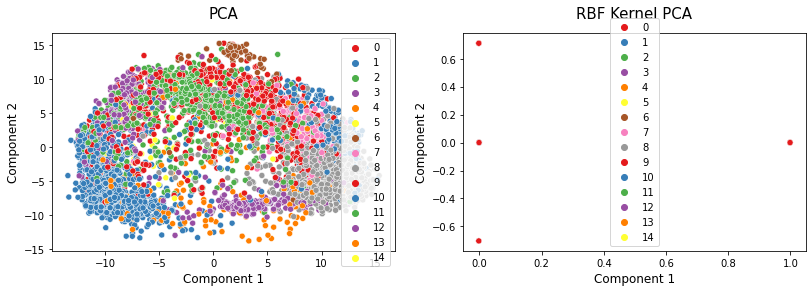

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5 ,4))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=y, palette='Set1', ax=ax[0])
sns.scatterplot(X_kpca[:, 0], X_kpca[:, 1], hue=y, palette='Set1', ax=ax[1])
ax[0].set_title("PCA", fontsize=15, pad=15)
ax[1].set_title("RBF Kernel PCA", fontsize=15, pad=15)
ax[0].set_xlabel("Component 1", fontsize=12)
ax[0].set_ylabel("Component 2", fontsize=12)
ax[1].set_xlabel("Component 1", fontsize=12)
ax[1].set_ylabel("Component 2", fontsize=12)
plt.savefig('PCA vs Kernel PCA.png', dpi=100)

In [ ]:
X_pca.shape , y.shape , X_val_pca.shape , y_val.shape , X_test_pca.shape, y_test.shape

((4802, 320), (4802,), (1201, 320), (1201,), (323, 320), (323,))

In [ ]:
X_kpca.shape , y.shape , X_val_kpca.shape , y_val.shape , X_test_kpca.shape, y_test.shape

((4802, 320), (4802,), (1201, 320), (1201,), (323, 320), (323,))

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,320,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model320 = Model(text_input, out)
model320.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model320.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 320)]       0         
                                                                 
 masking (Masking)           (None, None, 320)         0         
                                                                 
 lstm (LSTM)                 (None, 100)               168400    
                                                                 
 dense (Dense)               (None, 30)                3030      
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
Total params: 171,895
Trainable params: 171,895
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#creating the kpca dataframe for LSTM 
x_tr_kpca=[]
for i in range(df_train.shape[0]):
  x_tr_kpca.append(np.array(X_kpca[i],ndmin=2))
  # y_train.append(df_train["label"][i])
df_train_kpca = pd.DataFrame({'emb': x_tr_kpca, 'label': y, })
df_train_kpca.head()

x_va_kpca=[]
for i in range(df_val.shape[0]):
  x_va_kpca.append(np.array(X_val_kpca[i],ndmin=2))
df_val_kpca = pd.DataFrame({'emb': x_va_kpca, 'label': y_val, })
df_val_kpca.head()

x_te_kpca=[]
for i in range(df_test.shape[0]):
  x_te_kpca.append(np.array(X_test_kpca[i],ndmin=2))
df_test_kpca = pd.DataFrame({'emb': x_te_kpca, 'label': y_test, })
df_test_kpca.head()

,emb,label
0,"[[0.0, -0.0, 0.0, -0.0, 0.19381867, -0.0, 0.0,...",1
1,"[[0.0007487529, 0.002031984, -0.09290755, -0.0...",9
2,"[[-0.0063728355, 0.017037606, -0.1432983, -0.0...",8
3,"[[0.036207117, -0.012308282, -0.08399796, 0.01...",1
4,"[[0.029277353, 0.026137201, 0.02689116, -0.001...",4


In [ ]:
df_train_kpca.shape , df_val_kpca.shape , df_test_kpca.shape

((4802, 2), (1201, 2), (323, 2))

In [ ]:
#creating the pca dataframe for LSTM 

x_tr_pca=[]
for i in range(df_train.shape[0]):
  x_tr_pca.append(np.array(X_pca[i],ndmin=2))
  # y_train.append(df_train["label"][i])
df_train_pca = pd.DataFrame({'emb': x_tr_pca, 'label': y, })
df_train_pca.head()

x_va_pca=[]
for i in range(df_val.shape[0]):
  x_va_pca.append(np.array(X_val_pca[i],ndmin=2))
df_val_pca = pd.DataFrame({'emb': x_va_pca, 'label': y_val, })
df_val_pca.head()

x_te_pca=[]
for i in range(df_test.shape[0]):
  x_te_pca.append(np.array(X_test_pca[i],ndmin=2))
df_test_pca = pd.DataFrame({'emb': x_te_pca, 'label': y_test, })
df_test_pca.head()

,emb,label
0,"[[12.431176, -5.565358, -3.2977662, 2.3783424,...",1
1,"[[-2.3474836, 5.6842685, -4.719406, 4.8050823,...",9
2,"[[-9.93848, 2.8519666, -3.4420557, 3.3974466, ...",8
3,"[[12.951349, -4.7748213, -2.24862, 1.4130814, ...",1
4,"[[-2.1590223, -12.2340145, -2.533019, -2.72807...",4


In [ ]:
df_train_pca.shape , df_val_pca.shape , df_test_pca.shape

((4802, 2), (1201, 2), (323, 2))

In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 2
batches_per_epoch =  2401
assert batch_size * batches_per_epoch == num_sequences
num_features= 320
def train_generator_entire(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 1201
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 320
def val_generator_entire(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
#for the pca dataset 
model320.fit_generator(train_generator_entire(df_train_pca), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_entire(df_val_pca), validation_steps=batches_per_epoch_val, callbacks=[ES] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
2395/2401 [============================>.] - ETA: 0s - batch: 1197.0000 - size: 2.0000 - loss: 0.7839 - acc: 0.7787

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2401/2401 [==============================] - 12s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.7827 - acc: 0.7793 - val_loss: 0.8887 - val_acc: 0.7252
Epoch 2/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.5685 - acc: 0.8153 - val_loss: 0.9187 - val_acc: 0.7244
Epoch 3/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.4995 - acc: 0.8297 - val_loss: 0.9643 - val_acc: 0.7244
Epoch 4/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.4397 - acc: 0.8499 - val_loss: 1.0256 - val_acc: 0.7194
Epoch 5/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.3852 - acc: 0.8692 - val_loss: 1.0996 - val_acc: 0.7127
Epoch 6/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.3375 - acc: 0.8846 - val_loss: 1.1556 - val_acc: 0.71

In [ ]:
num_sequences_val = len(df_test_pca['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 323
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 320
model320.evaluate_generator(val_generator_entire(df_test_pca), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[3.76380944962472, 0.108359136]

In [ ]:
y_proba=model320.predict(val_generator_entire(df_test_pca), steps= batches_per_epoch_val)

y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)


#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_pca['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_pca['label']))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Confusion Matrix
[[ 2  0  0  5  0  0  1 58  5  2  0  2]
 [ 2  1  5  0  0  1 10 13 31  4  0  0]
 [ 0  0  1  0  0  0  4  1  0  1  0  2]
 [ 0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  2  4  0  1  0  0  0  1  1  4  0]
 [68  9  2  5  0  0  0  0  6  0  0  0]
 [ 0 31  0  0  0  0  0  1 16  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  1  0  0 13]]
Classification Report
              precision    recall  f1-score   support

           1       0.03      0.03      0.03        75
           2       0.02      0.01      0.02        67
           3       0.08      0.11      0.10         9
           4       0.09      0.50      0.15         2
           5       0.00      0.00      0.00         1
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        90
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_test_pca['label'].unique()

array([ 1,  9,  8,  4,  3,  2, 10,  7, 11, 12,  6,  5])

In [ ]:
mat = confusion_matrix(y_pred, df_test_pca['label'])

diag = np.diagonal(mat)
sum(diag)

35

In [ ]:
#kpca 
#KPCA
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,320,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model320kpca = Model(text_input, out)
model320kpca.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model320kpca.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 320)]       0         
                                                                 
 masking_1 (Masking)         (None, None, 320)         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               168400    
                                                                 
 dense_2 (Dense)             (None, 30)                3030      
                                                                 
 dense_3 (Dense)             (None, 15)                465       
                                                                 
Total params: 171,895
Trainable params: 171,895
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#for the pca dataset 
model320kpca.fit_generator(train_generator_entire(df_train_kpca), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_entire(df_val_kpca), validation_steps=batches_per_epoch_val, callbacks=[ES] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
2400/2401 [============================>.] - ETA: 0s - batch: 1199.5000 - size: 2.0000 - loss: 2.1498 - acc: 0.2190

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2401/2401 [==============================] - 10s 4ms/step - batch: 1200.0000 - size: 2.0000 - loss: 2.1498 - acc: 0.2189 - val_loss: 2.0928 - val_acc: 0.2322
Epoch 2/50
2401/2401 [==============================] - 9s 4ms/step - batch: 1200.0000 - size: 2.0000 - loss: 2.1026 - acc: 0.2303 - val_loss: 2.1112 - val_acc: 0.2043
Epoch 3/50
2401/2401 [==============================] - 9s 4ms/step - batch: 1200.0000 - size: 2.0000 - loss: 2.0703 - acc: 0.2453 - val_loss: 2.2411 - val_acc: 0.1858
Epoch 4/50
2401/2401 [==============================] - 9s 4ms/step - batch: 1200.0000 - size: 2.0000 - loss: 2.0263 - acc: 0.2638 - val_loss: 2.4287 - val_acc: 0.1734
Epoch 5/50
2401/2401 [==============================] - 9s 4ms/step - batch: 1200.0000 - size: 2.0000 - loss: 1.9959 - acc: 0.2753 - val_loss: 2.5919 - val_acc: 0.1796
Epoch 6/50
2401/2401 [==============================] - 9s 4ms/step - batch: 1200.0000 - size: 2.0000 - loss: 1.9740 - acc: 0.2872 - val_loss: 2.7135 - val_acc: 0.1765


In [ ]:
num_sequences_val = len(df_test_pca['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 323
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 320
model320kpca.evaluate_generator(val_generator_entire(df_test_kpca), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[2.0757514910063137, 0.21052632]

In [ ]:

y_proba=model320kpca.predict(val_generator_entire(df_test_kpca), steps= batches_per_epoch_val)

y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)


#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_kpca['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_kpca['label']))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Confusion Matrix
[[65 40  7  9  1  2 15 63 57  8  3 14]
 [ 7  3  5  2  0  0  2 12  3  1  1  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
Classification Report
              precision    recall  f1-score   support

           1       0.90      0.23      0.37       284
           2       0.07      0.08      0.07        39
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test_kpca['label'])

diag = np.diagonal(mat)
sum(diag)

68

# PCA with Transformer

In [ ]:
#Masking the input for same length 
num_features=320
def input_generator(df):
    x_list= df['emb'].to_list()
    y_list= df.label.to_list()
    timesteps = len(max(df['emb'].to_list(), key=len))
    x_train= np.full((df['emb'].shape[0], timesteps, num_features), -99.)
    y_train = np.zeros((df['emb'].shape[0],  1))
    for b in range(len(x_list)):
        x_train[b, 0:len(x_list[b]), :] = x_list[b]
        y_train[b]=y_list[b]
    return x_train, y_train


In [ ]:
x_train_new,y_train_new=input_generator(df_train_pca)
x_train_new.shape, y_train_new.shape

((4802, 1, 320), (4802, 1))

In [ ]:
x_val_new,y_val_new=input_generator(df_val_pca)
x_val_new.shape, y_val_new.shape

((1201, 1, 320), (1201, 1))

In [ ]:
x_test_new,y_test_new=input_generator(df_test_pca)
x_test_new.shape, y_test_new.shape

((323, 1, 320), (323, 1))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        #self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        print(positions)
        #x = self.token_emb(x)
        print(x)
        return x + positions


In [ ]:
vocab_size = 30  # Only consider the top 20k words
maxlen = 4  # Only consider the first 200 words of each movie review

In [ ]:

embed_dim = 320  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(None,320,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = inputs
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x,True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(15, activation="softmax")(x)

model_transpca = keras.Model(inputs=inputs, outputs=outputs)


Tensor("token_and_position_embedding/embedding/embedding_lookup/Identity_1:0", shape=(320, 320), dtype=float32)
Tensor("input_1:0", shape=(?, ?, 320), dtype=float32)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5)
callbacks_list = [early_stopping_monitor]

In [ ]:
model_transpca.compile("adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_transpca.fit(x_train_new, y_train_new, batch_size=32, epochs=100, validation_data=(x_val_new, y_val_new),callbacks =callbacks_list)

Train on 4802 samples, validate on 1201 samples
Epoch 1/100
4704/4802 [============================>.] - ETA: 0s - loss: 1.0940 - acc: 0.7190

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4802/4802 [==============================] - 1s 223us/sample - loss: 1.0906 - acc: 0.7197 - val_loss: 1.0884 - val_acc: 0.6919
Epoch 2/100
4802/4802 [==============================] - 1s 152us/sample - loss: 0.7582 - acc: 0.7861 - val_loss: 1.1283 - val_acc: 0.6911
Epoch 3/100
4802/4802 [==============================] - 1s 157us/sample - loss: 0.6936 - acc: 0.7901 - val_loss: 1.0239 - val_acc: 0.7069
Epoch 4/100
4802/4802 [==============================] - 1s 150us/sample - loss: 0.6300 - acc: 0.8036 - val_loss: 1.0686 - val_acc: 0.6928
Epoch 5/100
4802/4802 [==============================] - 1s 155us/sample - loss: 0.5888 - acc: 0.8128 - val_loss: 1.1672 - val_acc: 0.6836
Epoch 6/100
4802/4802 [==============================] - 1s 147us/sample - loss: 0.5865 - acc: 0.8109 - val_loss: 1.1651 - val_acc: 0.6811
Epoch 7/100
4802/4802 [==============================] - 1s 148us/sample - loss: 0.5507 - acc: 0.8259 - val_loss: 1.1826 - val_acc: 0.6853
Epoch 8/100
4802/4802 [================

In [ ]:
x_test_new,y_test_new=input_generator(df_test_pca)
x_test_new.shape, y_test_new.shape

((323, 1, 320), (323, 1))

In [ ]:
y_proba1=model_transpca.predict(x_test_new)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
y_pred=[]
for i in y_proba1:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_pca['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_pca['label']))


Confusion Matrix
[[ 1  0  0  4  0  0  0 52  9  2  0  4]
 [ 0  2  7  0  0  1 13 12 32  2  0  0]
 [ 1  3  1  0  0  0  4  4  2  3  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  1  3  0]
 [69 15  4  5  0  0  0  2  6  0  0  0]
 [ 1 22  0  0  0  0  0  3  8  1  0  2]
 [ 0  0  0  0  0  0  0  0  1  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  1  0  0 11]]
Classification Report
              precision    recall  f1-score   support

           1       0.01      0.01      0.01        72
           2       0.05      0.03      0.04        69
           3       0.08      0.06      0.07        18
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.03      0.02      0.02       101
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test_pca['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 25
No of misclassified samples :  298


In [ ]:
#KPCA 
x_train_new,y_train_new=input_generator(df_train_kpca)
x_train_new.shape, y_train_new.shape

((4802, 1, 320), (4802, 1))

In [ ]:
x_val_new,y_val_new=input_generator(df_val_kpca)
x_val_new.shape, y_val_new.shape

((1201, 1, 320), (1201, 1))

In [ ]:
x_test_new,y_test_new=input_generator(df_test_kpca)
x_test_new.shape, y_test_new.shape

((323, 1, 320), (323, 1))

In [ ]:

embed_dim = 320  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(None,320,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = inputs
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x,True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(15, activation="softmax")(x)

model_transkpca = keras.Model(inputs=inputs, outputs=outputs)


Tensor("token_and_position_embedding_1/embedding_1/embedding_lookup/Identity_1:0", shape=(320, 320), dtype=float32)
Tensor("input_2:0", shape=(?, ?, 320), dtype=float32)


In [ ]:
model_transkpca.compile("adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_transkpca.fit(x_train_new, y_train_new, batch_size=32, epochs=100, validation_data=(x_val_new, y_val_new),callbacks =callbacks_list)

Train on 4802 samples, validate on 1201 samples
Epoch 1/100
4576/4802 [===========================>..] - ETA: 0s - loss: 2.2710 - acc: 0.2111

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4802/4802 [==============================] - 1s 224us/sample - loss: 2.2699 - acc: 0.2110 - val_loss: 2.2089 - val_acc: 0.2090
Epoch 2/100
4802/4802 [==============================] - 1s 157us/sample - loss: 2.1383 - acc: 0.2278 - val_loss: 2.4138 - val_acc: 0.1932
Epoch 3/100
4802/4802 [==============================] - 1s 153us/sample - loss: 2.0882 - acc: 0.2470 - val_loss: 2.5897 - val_acc: 0.2015
Epoch 4/100
4802/4802 [==============================] - 1s 155us/sample - loss: 2.0591 - acc: 0.2518 - val_loss: 2.4146 - val_acc: 0.2048
Epoch 5/100
4802/4802 [==============================] - 1s 152us/sample - loss: 2.0425 - acc: 0.2520 - val_loss: 2.8858 - val_acc: 0.1782
Epoch 6/100
4802/4802 [==============================] - 1s 154us/sample - loss: 2.0210 - acc: 0.2643 - val_loss: 2.5808 - val_acc: 0.1882


In [ ]:
x_test_new,y_test_new=input_generator(df_test_kpca)
x_test_new.shape, y_test_new.shape

((323, 1, 320), (323, 1))

In [ ]:
y_proba1=model_transkpca.predict(x_test_new)

y_pred=[]
for i in y_proba1:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_kpca['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_kpca['label']))

Confusion Matrix
[[36 22  5  7  1  0  8 28 30  3  2  7]
 [ 9  3  1  0  0  1  2 14  6  1  0  5]
 [ 3  2  3  1  0  0  0  4  2  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  3  1  0  0]
 [12  9  1  3  0  0  4  9  9  0  1  3]
 [ 7  6  2  0  0  1  2 15  7  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  1  0  0  0  0  1  5  3  0  1  0]]
Classification Report
              precision    recall  f1-score   support

           1       0.50      0.24      0.33       149
           2       0.07      0.07      0.07        42
           3       0.25      0.18      0.21        17
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         6
           8       0.12      0.18      0.14        51
     

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test_kpca['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 58
No of misclassified samples :  265


# LSTM Network Entire Chunk Stack 

In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 2
batches_per_epoch =  2401
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator_entire(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 1201
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator_entire(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
modelS = Model(text_input, out)
modelS.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
modelS.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 768)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               347600    
_________________________________________________________________
dense (Dense)                (None, 30)                3030      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
Total params: 351,095
Trainable params: 351,095
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df_train['label']=df_train['label'].replace([-1], 0)
df_test['label']=df_test['label'].replace([-1], 0)
df_val['label']=df_val['label'].replace([-1], 0)

In [ ]:
df_train['label'].unique()

array([ 9,  2,  8,  1,  3, 12,  7,  5, 10,  4,  6,  0, 13, 11, 14])

In [ ]:
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
#First Time Run 
#Token size = 500, Earlier LSTM architecture 
#Accuracy is very low so interrupted in the middle 
modelS.fit_generator(train_generator_entire(df_train), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_entire(df_val), validation_steps=batches_per_epoch_val, callbacks=[ES] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50
2401/2401 [==============================] - ETA: 0s - batch: 1200.0000 - size: 2.0000 - loss: 0.8342 - acc: 0.7526

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2401/2401 [==============================] - 55s 22ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.8342 - acc: 0.7526 - val_loss: 0.9168 - val_acc: 0.7219
Epoch 2/50
2401/2401 [==============================] - 54s 22ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.7376 - acc: 0.7724 - val_loss: 0.9339 - val_acc: 0.7202
Epoch 3/50
2401/2401 [==============================] - 53s 22ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.7119 - acc: 0.7803 - val_loss: 0.8896 - val_acc: 0.7186
Epoch 4/50
2401/2401 [==============================] - 52s 22ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.6779 - acc: 0.7847 - val_loss: 0.9142 - val_acc: 0.7177
Epoch 5/50
2401/2401 [==============================] - 52s 22ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.6762 - acc: 0.7838 - val_loss: 0.9076 - val_acc: 0.7269
Epoch 6/50
2401/2401 [==============================] - 53s 22ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.6585 - acc: 0.7918 - val_loss: 0.9426 - val_acc

In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 323
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
modelS.evaluate_generator(val_generator_entire(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.6217815227858469, 0.7894737]

In [ ]:
y_proba=modelS.predict(val_generator_entire(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)


#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[66  0  0  5  0  0  0  0  2  0  0  0]
 [ 1 41  0  0  0  0  0  0  7  1  0  0]
 [ 0  1 11  0  0  0  0  1  2  0  0  0]
 [ 2  0  0  5  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  1  0  0  0]
 [ 1  0  1  0  0  0 16  0  4  2  0  0]
 [ 0  0  0  1  0  0  0 67 14  2  0  3]
 [ 2  1  0  0  0  0  1  3 26  1  0  0]
 [ 0  0  0  0  0  0  0  2  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  4  0]
 [ 0  0  0  0  0  0  0  2  1  0  0 14]]
Classification Report
              precision    recall  f1-score   support

           1       0.92      0.90      0.91        73
           2       0.95      0.82      0.88        50
           3       0.92      0.73      0.81        15
           4       0.45      0.50      0.48        10
           5       1.00      1.00      1.00         1
           6       1.00      0.67      0.80         3
           7       0.94      0.67      0.78        24
           8       0.89      0.77      0.83        87
     

In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
sum(diag)

255

# Head and Tail without chunks 

In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 2
batches_per_epoch =  2401
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator_entire(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 1201
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator_entire(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
modelHT = Model(text_input, out)
modelHT.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
modelHT.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking (Masking)           (None, None, 768)         0         
                                                                 
 lstm (LSTM)                 (None, 100)               347600    
                                                                 
 dense (Dense)               (None, 30)                3030      
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
Total params: 351,095
Trainable params: 351,095
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df_train['label']=df_train['label'].replace([-1], 0)
df_test['label']=df_test['label'].replace([-1], 0)
df_val['label']=df_val['label'].replace([-1], 0)

In [ ]:
df_train['label'].unique()

array([ 9,  2,  8,  1,  3, 12,  7,  5, 10,  4,  6,  0, 13, 11, 14])

In [ ]:
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
#First Time Run 
#Token size = 500, Earlier LSTM architecture 
#Accuracy is very low so interrupted in the middle 
modelHT.fit_generator(train_generator_entire(df_train), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_entire(df_val), validation_steps=batches_per_epoch_val, callbacks=[ES] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/50
2399/2401 [============================>.] - ETA: 0s - batch: 1199.0000 - size: 2.0000 - loss: 0.9380 - acc: 0.7201

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2401/2401 [==============================] - 12s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.9380 - acc: 0.7201 - val_loss: 0.9738 - val_acc: 0.6953
Epoch 2/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.8510 - acc: 0.7382 - val_loss: 0.9907 - val_acc: 0.6953
Epoch 3/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.8322 - acc: 0.7439 - val_loss: 0.9831 - val_acc: 0.7011
Epoch 4/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.8184 - acc: 0.7476 - val_loss: 0.9767 - val_acc: 0.7002
Epoch 5/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.8050 - acc: 0.7474 - val_loss: 0.9656 - val_acc: 0.7086
Epoch 6/50
2401/2401 [==============================] - 11s 5ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.7917 - acc: 0.7501 - val_loss: 0.9637 - val_acc: 0.69

In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 323
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
modelHT.evaluate_generator(val_generator_entire(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.784764650528645, 0.75232196]

In [ ]:
y_proba=modelHT.predict(val_generator_entire(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)


#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[60  1  2  4  0  0  0  2  2  0  0  0]
 [ 2 40  0  1  0  0  0  2 10  1  0  0]
 [ 1  0  9  0  0  0  0  1  2  0  0  0]
 [ 2  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  1  0  0  0]
 [ 1  0  1  0  0  0 16  1  5  1  0  0]
 [ 3  0  0  3  0  0  1 62 10  2  0  2]
 [ 2  2  0  0  0  0  0  3 28  1  0  0]
 [ 0  0  0  0  0  0  0  2  2  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  4  0]
 [ 1  0  0  0  0  0  0  1  0  0  0 15]]
Classification Report
              precision    recall  f1-score   support

           1       0.83      0.85      0.84        71
           2       0.93      0.71      0.81        56
           3       0.75      0.69      0.72        13
           4       0.27      0.60      0.37         5
           5       1.00      0.50      0.67         2
           6       1.00      0.67      0.80         3
           7       0.94      0.64      0.76        25
           8       0.83      0.75      0.78        83
     

In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
sum(diag)

243

# LSTM Stack Chunks with High variance

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
modelB = Model(text_input, out)
modelB.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
modelB.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                465       
Total params: 351,095
Trainable params: 351,095
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
#First Time Run 
#Token size = 500, Earlier LSTM architecture 
#Accuracy is very low so interrupted in the middle 
modelB.fit_generator(train_generator_entire(df_train_var), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_entire(df_val_var), validation_steps=batches_per_epoch_val , callbacks=[ES])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50
2398/2401 [============================>.] - ETA: 0s - batch: 1198.5000 - size: 2.0000 - loss: 0.8428 - acc: 0.7485

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2401/2401 [==============================] - 15s 6ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.8425 - acc: 0.7486 - val_loss: 0.9485 - val_acc: 0.7183
Epoch 2/50
2401/2401 [==============================] - 14s 6ms/step - batch: 1200.0000 - size: 2.0000 - loss: 0.7559 - acc: 0.7670 - val_loss: 0.9233 - val_acc: 0.7152
Epoch 3/50
2056/2401 [========================>.....] - ETA: 1s - batch: 1027.5000 - size: 2.0000 - loss: 0.7147 - acc: 0.7753

In [ ]:
num_sequences_val = len(df_test_var['emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 148
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
modelB.evaluate_generator(val_generator_entire(df_test_var), steps= batches_per_epoch_val)



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.8370251300480418, 0.7601351]

In [ ]:
y_proba=modelB.predict(val_generator_entire(df_test_var), steps= batches_per_epoch_val)

y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)


#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_var['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_var['label']))


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Confusion Matrix
[[60  0  0  4  0  0  0  5  0  0  0]
 [ 6 39  0  2  0  0  2  9  1  0  0]
 [ 1  0 10  1  0  0  0  3  0  0  0]
 [ 0  0  0  3  0  0  1  0  2  0  1]
 [ 0  0  0  0  3  0  0  1  0  0  0]
 [ 0  0  0  0  0  6  0  1  0  0  0]
 [ 1  0  0  0  0  0 58  9  3  1  2]
 [ 1  0  0  1  1  2  5 26  2  0  0]
 [ 0  0  0  0  0  0  1  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  1  0  0  0  0  0 15]]
Classification Report
              precision    recall  f1-score   support

           1       0.87      0.87      0.87        69
           2       1.00      0.66      0.80        59
           3       1.00      0.67      0.80        15
           4       0.25      0.43      0.32         7
           6       0.60      0.75      0.67         4
           7       0.75      0.86      0.80         7
           8       0.87      0.78      0.82        74
           9       0.48      0.68      0.57        38
          10       0.33      0.80      0.47         5
          11       0.50

In [ ]:
mat = confusion_matrix(y_pred, df_test_var['label'])

diag = np.diagonal(mat)
sum(diag)

225

# Transformer Input Creation

In [ ]:
#Masking the input for same length 
num_features=768
def input_generator(df):
    x_list= df['emb'].to_list()
    y_list= df.label.to_list()
    timesteps = len(max(df['emb'].to_list(), key=len))
    x_train= np.full((df['emb'].shape[0], timesteps, num_features), -99.)
    y_train = np.zeros((df['emb'].shape[0],  1))
    for b in range(len(x_list)):
        x_train[b, 0:len(x_list[b]), :] = x_list[b]
        y_train[b]=y_list[b]
    return x_train, y_train


In [ ]:
x_train_new,y_train_new=input_generator(df_train)
x_train_new.shape, y_train_new.shape

((5060, 20, 768), (5060, 1))

In [ ]:
x_val_new,y_val_new=input_generator(df_val)
x_val_new.shape, y_val_new.shape

((759, 20, 768), (759, 1))

In [ ]:
x_test_new,y_test_new=input_generator(df_test)
x_test_new.shape, y_test_new.shape

((507, 20, 768), (507, 1))

# Transfomer Network

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        #self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        print(positions)
        #x = self.token_emb(x)
        print(x)
        return x + positions


In [ ]:
vocab_size = 30  # Only consider the top 20k words
maxlen = 4  # Only consider the first 200 words of each movie review

In [ ]:

embed_dim = 768  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(None,768,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = inputs
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x,True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(15, activation="softmax")(x)

model_trans = keras.Model(inputs=inputs, outputs=outputs)


Tensor("token_and_position_embedding/embedding/embedding_lookup/Identity_1:0", shape=(768, 768), dtype=float32)
Tensor("input_1:0", shape=(?, ?, 768), dtype=float32)


In [ ]:
model_trans.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 768)]       0         
                                                                 
 transformer_block (Transfor  (None, None, 768)        4776992   
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 768)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_3 (Dropout)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 20)                15380     
                                                                 
 dropout_4 (Dropout)         (None, 20)                0   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5)
callbacks_list = [early_stopping_monitor]

In [ ]:
model_trans.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model_trans.fit(x_train_new, y_train_new, batch_size=32, epochs=100, validation_data=(x_val_new, y_val_new),callbacks =callbacks_list)

Train on 5060 samples, validate on 759 samples
Epoch 1/100
5024/5060 [============================>.] - ETA: 0s - loss: 0.7379 - acc: 0.7651

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5060/5060 [==============================] - 2s 357us/sample - loss: 0.7366 - acc: 0.7658 - val_loss: 0.9061 - val_acc: 0.7378
Epoch 2/100
5060/5060 [==============================] - 1s 279us/sample - loss: 0.7022 - acc: 0.7719 - val_loss: 0.8660 - val_acc: 0.7352
Epoch 3/100
5060/5060 [==============================] - 1s 279us/sample - loss: 0.6904 - acc: 0.7794 - val_loss: 0.8925 - val_acc: 0.7220
Epoch 4/100
5060/5060 [==============================] - 1s 292us/sample - loss: 0.7276 - acc: 0.7700 - val_loss: 0.9013 - val_acc: 0.7101
Epoch 5/100
5060/5060 [==============================] - 1s 280us/sample - loss: 0.7282 - acc: 0.7686 - val_loss: 0.8271 - val_acc: 0.7339
Epoch 6/100
5060/5060 [==============================] - 1s 278us/sample - loss: 0.7130 - acc: 0.7698 - val_loss: 0.8666 - val_acc: 0.7299
Epoch 7/100
5060/5060 [==============================] - 1s 277us/sample - loss: 0.7360 - acc: 0.7690 - val_loss: 0.8829 - val_acc: 0.7286
Epoch 8/100
5060/5060 [================

In [ ]:
x_test_new,y_test_new=input_generator(df_test)
x_test_new.shape, y_test_new.shape

((507, 20, 768), (507, 1))

In [ ]:
y_proba=model_trans.predict(x_test_new)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))


Confusion Matrix
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 100   3   2   5   0   0   0   0  12   0   0   0]
 [  0   5  60   2   3   2   0   1   2  20   0   0   0]
 [  0   0   1  25   1   0   0   0   2   3   1   0   0]
 [  0   2   0   0   9   0   0   0   1   1   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   1   0   0   0   0]
 [  0   1   0   0   0   0   0  13   0   0   2   0   0]
 [  0   4   0   0   1   0   0   2  96   9   9   2   4]
 [  1   3   3   3   2   2   0   1   9  39   3   0   0]
 [  0   0   0   1   0   0   0   1   4   0  11   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   2   0]
 [  0   0   1   0   0   0   0   0   0   1   0   0  10]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.86      0.82      0.84       122
           2       0.88      0.63      0.74        95
           3       0.76     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 367
No of misclassified samples :  140


# Autoencoders_New2_Stack Emb

In [ ]:
# AutoEncoder Model Preparation
n_inputs = tr_emb.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*2)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

In [ ]:
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model_full = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model_full.compile(optimizer='adam', loss='mse')

In [ ]:
# fit the autoencoder model to reconstruct input
model_full.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_8 (Dense)             (None, 1536)              1181184   
                                                                 
 batch_normalization_4 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1536)              0         
                                                                 
 dense_9 (Dense)             (None, 768)               1180416   
                                                                 
 batch_normalization_5 (Batc  (None, 768)              3072      
 hNormalization)                                           

In [ ]:
history_full = model_full.fit(tr_emb, tr_emb, epochs=50, batch_size=16, verbose=2, validation_data=(val_emb,val_emb))

Train on 45912 samples, validate on 11707 samples
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


45912/45912 - 15s - loss: 0.0435 - val_loss: 0.0234 - 15s/epoch - 321us/sample
Epoch 2/50
45912/45912 - 14s - loss: 0.0233 - val_loss: 0.0131 - 14s/epoch - 304us/sample
Epoch 3/50
45912/45912 - 14s - loss: 0.0178 - val_loss: 0.0098 - 14s/epoch - 305us/sample
Epoch 4/50
45912/45912 - 14s - loss: 0.0146 - val_loss: 0.0088 - 14s/epoch - 306us/sample
Epoch 5/50
45912/45912 - 14s - loss: 0.0123 - val_loss: 0.0077 - 14s/epoch - 305us/sample
Epoch 6/50
45912/45912 - 14s - loss: 0.0109 - val_loss: 0.0073 - 14s/epoch - 308us/sample
Epoch 7/50
45912/45912 - 14s - loss: 0.0100 - val_loss: 0.0058 - 14s/epoch - 308us/sample
Epoch 8/50
45912/45912 - 14s - loss: 0.0090 - val_loss: 0.0057 - 14s/epoch - 303us/sample
Epoch 9/50
45912/45912 - 14s - loss: 0.0083 - val_loss: 0.0056 - 14s/epoch - 302us/sample
Epoch 10/50
45912/45912 - 14s - loss: 0.0079 - val_loss: 0.0054 - 14s/epoch - 302us/sample
Epoch 11/50
45912/45912 - 14s - loss: 0.0073 - val_loss: 0.0051 - 14s/epoch - 307us/sample
Epoch 12/50
45912/4

In [ ]:
encoder_full = Model(inputs=input_data_shape, outputs=bottleneck)

encoded_X_train_full = encoder_full.predict(tr_emb)
encoded_X_val_full = encoder_full.predict(val_emb)

encoded_X_train_full.shape, encoded_X_val_full.shape

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


((45912, 384), (11707, 384))

In [ ]:
aux = -1
len_l = 0
train_x_ae = {}
for l, emb in zip(index_l, encoded_X_train_full):
  if l in train_x_ae.keys():
    train_x_ae[l]  =np.vstack([train_x_ae[l], emb])
  else:
    train_x_ae[l] = [emb]

len(train_x_ae.keys())

train_l_final = []
label_l_final = []
for k in train_x_ae.keys():
  train_l_final.append(train_x_ae[k])
  label_l_final.append(train.loc[k]['label'])

df_train_ME = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train_ME.head()

,emb,label
0,"[[11.7691345, -3.993317, -2.3697932, 0.9409576...",9
1,"[[27.210913, -3.0984569, -2.3482087, -21.91563...",1
2,"[[3.8793087, -44.26941, -3.7535632, -1.2752479...",2
3,"[[8.875746, -9.7351055, -7.829488, -0.16122623...",8
4,"[[8.827965, -31.248112, 0.33624804, 2.5537694,...",9


In [ ]:
aux = -1
len_l = 0
val_x_ae = {}

for l, emb in zip(val_index_l, encoded_X_val_full):
  if l in val_x_ae.keys():
    val_x_ae[l]  =np.vstack([val_x_ae[l], emb])
  else:
    val_x_ae[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x_ae.keys():
  val_l_final.append(val_x_ae[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val_ME = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val_ME.head()

,emb,label
0,"[[-9.790737, 26.58396, -1.7922839, -2.1424522,...",1
1,"[[-0.4056447, -54.6055, 0.6750471, 0.9529122, ...",2
2,"[[6.774913, 10.040265, -0.9872214, -19.450104,...",1
3,"[[15.251167, 16.838892, -6.065732, -1.8918027,...",10
4,"[[-4.0619407, 6.8484197, -4.5793467, 6.1958485...",1


In [ ]:
df_train_ME['text_split_count'] = df_train_ME['emb'].apply(new_get_split_count)
df_val_ME['text_split_count'] = df_val_ME['emb'].apply(new_get_split_count)

In [ ]:
df_train_ME.shape, df_val_ME.shape

((5060, 3), (1266, 3))

In [ ]:
df_train_ME

,emb,label,text_split_count
0,"[[11.7691345, -3.993317, -2.3697932, 0.9409576...",9,1
1,"[[27.210913, -3.0984569, -2.3482087, -21.91563...",1,4
2,"[[3.8793087, -44.26941, -3.7535632, -1.2752479...",2,16
3,"[[8.875746, -9.7351055, -7.829488, -0.16122623...",8,5
4,"[[8.827965, -31.248112, 0.33624804, 2.5537694,...",9,9
...,...,...,...
5055,"[[18.391924, -31.185476, -6.34667, -0.6771315,...",9,1
5056,"[[4.3742423, -22.228655, -5.4029665, 4.9805613...",2,5
5057,"[[23.31708, 3.213971, -2.7555082, -1.3329479, ...",8,4
5058,"[[1.5350021, -23.772484, -6.695416, -1.2198218...",3,1


In [ ]:
df_test_ME_1 = df_train_ME[(df_train_ME['text_split_count'].isin([4]))]
df_train_ME_1 = df_train_ME[~(df_train_ME['text_split_count'].isin([4]))]
df_train_ME = df_train_ME_1
print(df_train_ME.shape , df_test_ME_1.shape)

(4802, 3) (258, 3)


In [ ]:
df_test_ME_2 = df_val_ME[(df_val_ME['text_split_count'].isin([4]))]
df_val_ME_1 = df_val_ME[~(df_val_ME['text_split_count'].isin([4]))]
df_val_ME = df_val_ME_1

In [ ]:

df_test_ME_new = [df_test_ME_1, df_test_ME_2]
df_test_ME_nw_1 = pd.concat(df_test_ME_new)

df_test_ME = df_test_ME_nw_1
df_test_ME.reset_index(drop=True, inplace=True)
df_test_ME.head(2)


,emb,label,text_split_count
0,"[[27.210913, -3.0984569, -2.3482087, -21.91563...",1,4
1,"[[3.8061097, 28.144135, -2.9049828, 3.2746058,...",9,4


In [ ]:

df_train_ME.reset_index(drop=True, inplace=True)
df_train_ME.head(2)


,emb,label,text_split_count
0,"[[11.7691345, -3.993317, -2.3697932, 0.9409576...",9,1
1,"[[3.8793087, -44.26941, -3.7535632, -1.2752479...",2,16


In [ ]:
df_val_ME.reset_index(drop=True, inplace=True)
df_val_ME.head(2)

,emb,label,text_split_count
0,"[[-9.790737, 26.58396, -1.7922839, -2.1424522,...",1,1
1,"[[-0.4056447, -54.6055, 0.6750471, 0.9529122, ...",2,13


In [ ]:
df_train_ME.shape, df_val_ME.shape, df_test_ME.shape

((4802, 3), (1201, 3), (323, 3))

In [ ]:
df_train_ME['label']=df_train_ME['label'].replace([-1], 0)
df_val_ME['label']=df_val_ME['label'].replace([-1], 0)
df_test_ME['label']=df_test_ME['label'].replace([-1], 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
num_sequences = len(df_train_ME['emb'].to_list())
batch_size = 7
batches_per_epoch = 686
assert batch_size * batches_per_epoch == num_sequences
num_features= 384
def train_generator_encoder(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val_ME['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 1201
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 384
def val_generator_encoder(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
text_input = Input(shape=(None,384,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train_AE['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
modelME = Model(text_input, out)
modelME.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
modelME.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 384)]       0         
                                                                 
 masking_1 (Masking)         (None, None, 384)         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               194000    
                                                                 
 dense_14 (Dense)            (None, 30)                3030      
                                                                 
 dense_15 (Dense)            (None, 15)                465       
                                                                 
Total params: 197,495
Trainable params: 197,495
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
modelME.fit_generator(train_generator_encoder(df_train_ME), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_encoder(df_val_ME), validation_steps=batches_per_epoch_val,callbacks=[ES])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
685/686 [============================>.] - ETA: 0s - batch: 342.0000 - size: 7.0000 - loss: 0.9122 - acc: 0.7339

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


686/686 [==============================] - 21s 30ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.9118 - acc: 0.7341 - val_loss: 0.9568 - val_acc: 0.7061
Epoch 2/50
686/686 [==============================] - 20s 30ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.7436 - acc: 0.7751 - val_loss: 0.9392 - val_acc: 0.7136
Epoch 3/50
686/686 [==============================] - 20s 29ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.7041 - acc: 0.7797 - val_loss: 0.9036 - val_acc: 0.7136
Epoch 4/50
686/686 [==============================] - 20s 30ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.6875 - acc: 0.7774 - val_loss: 0.9137 - val_acc: 0.7186
Epoch 5/50
686/686 [==============================] - 20s 29ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.6700 - acc: 0.7870 - val_loss: 0.8906 - val_acc: 0.7336
Epoch 6/50
686/686 [==============================] - 20s 29ms/step - batch: 342.5000 - size: 7.0000 - loss: 0.6602 - acc: 0.7861 - val_loss: 0.8955 - val_acc: 0.7236
Epoch 7/5

In [ ]:
num_sequences_val = len(df_test_ME['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 323
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 384
modelME.evaluate_generator(val_generator_encoder(df_test_ME), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.6396259436147409, 0.7987616]

In [ ]:
y_proba=modelME.predict(val_generator_encoder(df_test_ME), steps= batches_per_epoch_val)
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_ME['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_ME['label']))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Confusion Matrix
[[67  0  0  4  0  0  0  0  3  0  0  0]
 [ 2 41  0  1  0  0  1  0  7  1  0  0]
 [ 0  1 11  0  0  0  0  1  1  0  0  0]
 [ 2  0  0  5  0  0  0  1  4  0  1  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 15  0  4  2  0  0]
 [ 0  0  0  1  0  0  1 65  9  2  0  2]
 [ 1  1  0  0  0  0  0  1 31  1  0  0]
 [ 0  0  0  0  0  0  0  5  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  1  1  3  0]
 [ 0  0  0  0  0  0  0  2  0  0  0 15]]
Classification Report
              precision    recall  f1-score   support

           1       0.93      0.91      0.92        74
           2       0.95      0.77      0.85        53
           3       0.92      0.79      0.85        14
           4       0.45      0.38      0.42        13
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       0.88      0.68      0.77        22
           8       0.87      0.81      0.84        80
     

In [ ]:
mat = confusion_matrix(y_pred, df_test_ME['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 258
No of misclassified samples :  65


# Autoencoders New 

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model

In [ ]:
model = Sequential()

model.add(Dense(600, activation = 'elu' , input_shape=(X.shape[1],)))
model.add(Dense(512, activation='linear',name='bottleneck'))

model.add(Dense(600 , activation = 'elu'))
model.add(Dense(X.shape[1],activation='elu'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

ES=tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
history=model.fit(X, X, batch_size=4, epochs = 250, verbose = 1, validation_data=(X_val, X_val), callbacks=[ES])

Train on 5060 samples, validate on 759 samples
Epoch 1/250
5056/5060 [============================>.] - ETA: 0s - loss: 0.8991 - mean_squared_error: 0.8991

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5060/5060 [==============================] - 2s 451us/sample - loss: 0.8994 - mean_squared_error: 0.8994 - val_loss: 1.3393 - val_mean_squared_error: 1.3393
Epoch 2/250
5060/5060 [==============================] - 2s 406us/sample - loss: 1.3489 - mean_squared_error: 1.3489 - val_loss: 1.3393 - val_mean_squared_error: 1.3393
Epoch 3/250
5060/5060 [==============================] - 2s 397us/sample - loss: 1.3483 - mean_squared_error: 1.3483 - val_loss: 1.3393 - val_mean_squared_error: 1.3393
Epoch 4/250
5060/5060 [==============================] - 2s 401us/sample - loss: 1.3482 - mean_squared_error: 1.3482 - val_loss: 1.3393 - val_mean_squared_error: 1.3393
Epoch 5/250
5060/5060 [==============================] - 2s 399us/sample - loss: 1.3495 - mean_squared_error: 1.3495 - val_loss: 1.3393 - val_mean_squared_error: 1.3393
Epoch 6/250
5060/5060 [==============================] - 2s 400us/sample - loss: 1.4849 - mean_squared_error: 1.4849 - val_loss: 1.3393 - val_mean_squared_error: 1.339

In [ ]:
encoder=Model(model.input, model.get_layer('bottleneck').output)
encoded_X_train = encoder.predict(X)
encoded_X_val = encoder.predict(X_val)
encoded_X_test = encoder.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
encoded_X_train.shape, encoded_X_val.shape, encoded_X_test.shape

((5060, 512), (759, 512), (507, 512))

In [ ]:
df_train['emb'][2].shape

(16, 768)

In [ ]:
df_train['label']=df_train['label'].replace([-1], 0)
df_test['label']=df_test['label'].replace([-1], 0)
df_val['label']=df_val['label'].replace([-1], 0)

In [ ]:
text_inputN = Input(shape=(None,768,), dtype='float32', name='text')

l_maskN = layers.Masking(mask_value=-99.)(text_inputN)
# Which we encoded in a single vector via a LSTM
encoded_textN = layers.LSTM(100,)(l_maskN)
out_denseN = layers.Dense(30, activation='relu')(encoded_textN)
# And we add a softmax classifier on top
outN = layers.Dense(len(df_train['label'].unique()), activation='softmax')(out_denseN)
# At model instantiation, we specify the input and the output:
modelN = Model(text_inputN, outN)
modelN.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
modelN.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_3 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_9 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_10 (Dense)             (None, 15)                465       
Total params: 351,095
Trainable params: 351,095
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_new = []
for i in range(len(encoded_X_train)):
  train_new.append(encoded_X_train[i])

val_new = []
for i in range(len(encoded_X_val)):
  val_new.append(encoded_X_val[i])

test_new = []
for i in range(len(encoded_X_test)):
  test_new.append(encoded_X_test[i])

In [ ]:
df_train_AE = pd.DataFrame({'emb': train_new, 'label': df_train['label'], })
df_train_AE.head()

,emb,label
0,"[-4.67915, 14.9925995, -8.871437, 16.083887, 8...",9
1,"[-3.3695483, -2.4736948, -9.841375, -11.606050...",1
2,"[-3.0292652, 6.734414, -9.845285, 4.3997297, 2...",2
3,"[2.4784546, -4.254761, 5.6292405, -1.0563029, ...",8
4,"[-4.1427965, -0.8965905, -10.766226, -8.453402...",9


In [ ]:
df_val_AE = pd.DataFrame({'emb': val_new, 'label': df_val['label'], })
df_val_AE.head()

,emb,label
0,"[3.2769277, -6.4149966, 7.629345, -1.6179233, ...",12
1,"[-2.959204, -2.536295, -8.7502365, -11.431156,...",1
2,"[-3.6973448, -2.2121837, -10.129915, -11.41050...",1
3,"[-1.8190556, 4.150242, -9.122379, 1.8094193, 2...",8
4,"[-1.4909492, -0.5826072, -4.460362, -3.3540986...",2


In [ ]:
df_test_AE = pd.DataFrame({'emb': test_new, 'label': df_test['label'], })
df_test_AE.head()

,emb,label
0,"[-3.6503603, -0.55987227, -8.924975, -4.923238...",9
1,"[-3.0534694, -1.7894884, -9.89627, -10.230881,...",1
2,"[-3.9207113, 8.376297, -9.505156, 6.712466, 2....",2
3,"[-3.3240027, -0.9326233, -9.668903, -7.5797405...",9
4,"[-0.616606, -1.0447502, -2.596106, -3.861605, ...",8


In [ ]:
df_train_AE.shape, df_val_AE.shape, df_test_AE.shape

((5060, 2), (759, 2), (507, 2))

In [ ]:
df_train

,emb,label,mean_emb,text_split_count
0,"[[0.7950534, 0.7987839, -0.5798624, -0.0508178...",9,"[0.7950534, 0.7987839, -0.5798624, -0.05081780...",1
1,"[[0.12968883, -0.11246501, 0.0016679895, 0.956...",1,"[0.11329858, -0.11095709, 0.043547444, 0.95512...",4
2,"[[0.8182535, -0.21112083, -0.8181701, -0.35678...",2,"[0.7697828, -0.113244, -0.6361579, -0.42223746...",16
3,"[[0.74388504, 0.106950656, 0.90599614, -0.9093...",8,"[0.70047396, -0.1488549, 0.90476876, -0.837227...",5
4,"[[0.59883034, -0.1979168, -0.7636861, 0.747686...",9,"[0.43300697, -0.13384393, -0.56491405, 0.70887...",9
...,...,...,...,...
5055,"[[0.6929994, 0.31415126, -0.98030996, 0.813554...",9,"[0.6929994, 0.31415126, -0.98030996, 0.8135544...",1
5056,"[[0.926246, -0.06501992, -0.08635644, -0.80418...",2,"[0.836391, 0.018573046, 0.08795969, -0.7785867...",5
5057,"[[0.79223984, 0.7453048, 0.91597915, -0.592504...",8,"[0.8179708, 0.558161, 0.9342796, -0.6502747, -...",4
5058,"[[0.5369305, -0.47789952, -0.94524497, 0.86575...",3,"[0.5369305, -0.47789952, -0.94524497, 0.865755...",1


In [ ]:
df_train_AE['label']=df_train_AE['label'].replace([-1], 0)
df_test_AE['label']=df_test_AE['label'].replace([-1], 0)
df_val_AE['label']=df_val_AE['label'].replace([-1], 0)

In [ ]:
df_train_AE['label'].unique()

array([ 9,  1,  2,  8,  3, 12,  7,  5, 10,  4,  6,  0, 13, 11, 14])

In [ ]:
num_sequences = len(df_train_AE['emb'].to_list())
batch_size = 5
batches_per_epoch = 1012
assert batch_size * batches_per_epoch == num_sequences
num_features= 512
def train_generator_encoder(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val_AE['emb'].to_list())
batch_size_val = 3
batches_per_epoch_val = 253
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 512
def val_generator_encoder(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
text_input = Input(shape=(None,512,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(df_train_AE['label'].unique()), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
modelAuto = Model(text_input, out)
modelAuto.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
modelAuto.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 512)]       0         
_________________________________________________________________
masking_4 (Masking)          (None, None, 512)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               245200    
_________________________________________________________________
dense_11 (Dense)             (None, 30)                3030      
_________________________________________________________________
dense_12 (Dense)             (None, 15)                465       
Total params: 248,695
Trainable params: 248,695
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ES=tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

In [ ]:
modelAuto.fit_generator(train_generator_encoder(df_train_AE), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_encoder(df_val_AE), validation_steps=batches_per_epoch_val,callbacks=[ES])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50
1012/1012 [==============================] - 453s 448ms/step - batch: 505.5000 - size: 5.0000 - loss: 0.9318 - acc: 0.7154 - val_loss: 1.0808 - val_acc: 0.6653
Epoch 2/50
1012/1012 [==============================] - 451s 445ms/step - batch: 505.5000 - size: 5.0000 - loss: 0.9249 - acc: 0.7123 - val_loss: 1.1096 - val_acc: 0.6416
Epoch 3/50
1012/1012 [==============================] - 448s 442ms/step - batch: 505.5000 - size: 5.0000 - loss: 0.9256 - acc: 0.7134 - val_loss: 1.0358 - val_acc: 0.6825
Epoch 4/50
1012/1012 [==============================] - 449s 444ms/step - batch: 505.5000 - size: 5.0000 - loss: 0.9026 - acc: 0.7196 - val_loss: 1.0462 - val_acc: 0.6864
Epoch 5/50
1012/1012 [==============================] - 451s 446ms/step - batch: 505.5000 - size: 5.0000 - loss: 0.8881 - acc: 0.7289 - val_loss: 1.0364 - val_acc: 0.6838
Epoch 6/50
1012/1012 [==============================] - 452s 447ms/step - batch: 505.5000 - size: 5.0000 - loss: 0.8556 - acc: 0.7379 - val_loss:

In [ ]:
df_train['label'].unique()

array([ 9,  1,  2,  8,  3, 12,  7,  5, 10,  4,  6,  0, 13, 11, 14])

In [ ]:
num_sequences_val = len(df_test_AE['emb'].to_list())
batch_size_val = 3
batches_per_epoch_val = 169
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 512
modelAuto.evaluate_generator(val_generator_encoder(df_test_AE), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.003203493449286, 0.68244576]

In [ ]:
y_proba=modelAuto.predict(val_generator_encoder(df_test_AE), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_AE['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_AE['label']))

Confusion Matrix
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 102   4   2   4   0   0   0   0   8   0   0   0]
 [  0   4  45   3   3   2   0   0   2  20   1   0   0]
 [  0   1   0  24   1   0   0   0   2   2   0   0   0]
 [  0   2   0   0   8   0   0   0   1   1   2   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   2   0   0   0   0]
 [  0   1   0   0   0   0   0  13   0   0   1   0   1]
 [  0   1   3   0   3   0   0   3  94  18   6   1   2]
 [  1   5  15   4   2   1   0   1   8  35   5   0   0]
 [  0   0   0   0   0   0   0   1   5   0  10   0   0]
 [  0   0   0   0   0   1   0   0   0   0   1   2   0]
 [  0   0   1   0   0   0   0   0   1   1   0   0  11]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.88      0.85      0.86       120
           2       0.66      0.56      0.61        80
           3       0.73     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test_AE['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 346
No of misclassified samples :  161


# Autoencoders

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               384500    
_________________________________________________________________
dense_14 (Dense)             (None, 768)               384768    
Total params: 769,268
Trainable params: 769,268
Non-trainable params: 0
_________________________________________________________________
Train on 5060 samples, validate on 759 samples
Epoch 1/50
5060/5060 [==============================] - 0s 56us/sample - loss: -1.3930 - mean_squared_error: 0.3366 - val_loss: -5.8489 - val_mean_squared_error: 0.2517
Epoch 2/50
 256/5060 [>.............................] - ETA: 0s - loss: -6.0773 - mean_squared_error: 0.2558

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5060/5060 [==============================] - 0s 13us/sample - loss: -16.2659 - mean_squared_error: 0.2594 - val_loss: -32.5235 - val_mean_squared_error: 0.2592
Epoch 3/50
5060/5060 [==============================] - 0s 12us/sample - loss: -57.8153 - mean_squared_error: 0.2658 - val_loss: -91.7409 - val_mean_squared_error: 0.2651
Epoch 4/50
5060/5060 [==============================] - 0s 13us/sample - loss: -135.8962 - mean_squared_error: 0.2713 - val_loss: -190.2362 - val_mean_squared_error: 0.2700
Epoch 5/50
5060/5060 [==============================] - 0s 13us/sample - loss: -255.2860 - mean_squared_error: 0.2752 - val_loss: -330.8467 - val_mean_squared_error: 0.2730
Epoch 6/50
5060/5060 [==============================] - 0s 13us/sample - loss: -417.6955 - mean_squared_error: 0.2785 - val_loss: -514.3993 - val_mean_squared_error: 0.2764
Epoch 7/50
5060/5060 [==============================] - 0s 13us/sample - loss: -624.2160 - mean_squared_error: 0.2814 - val_loss: -740.9342 - val_mean

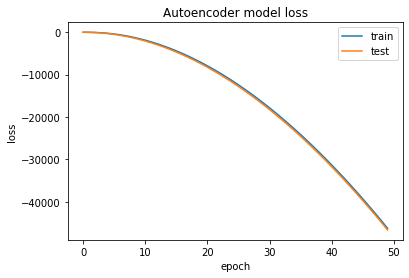

In [ ]:
encoding_dim = 500

# Define input layer
input_data = Input(shape=(768,))
# Define encoding layer
encoded = Dense(encoding_dim, activation='relu')(input_data)
# Define decoding layer
decoded = Dense(768, activation='sigmoid')(encoded)
# Create the autoencoder model
autoencoder = Model(input_data, decoded)
#Compile the autoencoder model
autoencoder.compile(metrics = ['mse'],
                    optimizer='adam',
                    loss='binary_crossentropy')

autoencoder.summary()

#Fit to train set, validate with dev set and save to hist_auto for plotting purposes
hist_auto = autoencoder.fit(X, X, epochs = 50, batch_size=256, shuffle=True, validation_data=(X_val, X_val))
#(train_x, train_x, epochs=50)
#, batch_size=256, shuffle=True, validation_data=(dev_x, dev_x))

# Summarize history for loss
plt.figure()
plt.plot(hist_auto.history['loss'])
plt.plot(hist_auto.history['val_loss'])
plt.title('Autoencoder model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
encoder = Model(input_data, encoded)
encoded_X_train = encoder.predict(X)

encoder = Model(input_data, encoded)
encoded_X_val = encoder.predict(X_val)

encoder = Model(input_data, encoded)
encoded_X_test = encoder.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
encoded_X_train.shape, encoded_X_val.shape, encoded_X_test.shape

((5060, 500), (759, 500), (507, 500))

In [ ]:
text_input = Input(shape=(None,500,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(15, activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
modelAuto = Model(text_input, out)
modelAuto.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
modelAuto.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 500)]       0         
_________________________________________________________________
masking_5 (Masking)          (None, None, 500)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_15 (Dense)             (None, 30)                3030      
_________________________________________________________________
dense_16 (Dense)             (None, 15)                465       
Total params: 243,895
Trainable params: 243,895
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_new = []
for i in range(len(encoded_X_train)):
  train_new.append(encoded_X_train[i])

val_new = []
for i in range(len(encoded_X_val)):
  val_new.append(encoded_X_val[i])

test_new = []
for i in range(len(encoded_X_test)):
  test_new.append(encoded_X_test[i])

In [ ]:
df_train_AE = pd.DataFrame({'emb': train_new, 'label': df_train['label'], })
df_train_AE.head()

,emb,label
0,"[392.56375, 547.6669, 504.9725, 423.85358, 555...",9
1,"[519.32214, 366.5688, 407.1145, 493.3068, 325....",1
2,"[302.46243, 399.47687, 377.7629, 325.2899, 392...",2
3,"[151.88489, 230.6746, 225.86288, 171.41588, 25...",8
4,"[516.7826, 427.3497, 447.02066, 503.27594, 384...",9


In [ ]:
df_val_AE = pd.DataFrame({'emb': val_new, 'label': df_val['label'], })
df_val_AE.head()

,emb,label
0,"[107.75294, 69.13308, 85.57257, 102.41434, 81....",12
1,"[501.68134, 408.11072, 443.12302, 489.4288, 38...",1
2,"[551.929, 421.94965, 459.01422, 530.9804, 383....",1
3,"[280.30225, 446.2919, 407.82178, 313.38422, 47...",8
4,"[214.00519, 330.5726, 311.8937, 241.03583, 346...",2


In [ ]:
df_test_AE = pd.DataFrame({'emb': test_new, 'label': df_test['label'], })
df_test_AE.head()

,emb,label
0,"[484.2983, 480.5238, 491.33838, 489.17078, 469...",9
1,"[443.86356, 391.04935, 423.57224, 439.96548, 3...",1
2,"[362.10455, 439.25363, 419.40692, 381.60886, 4...",2
3,"[504.5503, 458.1713, 469.18622, 499.40295, 428...",9
4,"[251.56934, 350.69974, 345.0494, 274.1809, 396...",8


In [ ]:
df_train_AE.shape, df_val_AE.shape, df_test_AE.shape

((5060, 2), (759, 2), (507, 2))

In [ ]:
num_sequences = len(df_train_AE['emb'].to_list())
batch_size = 5
batches_per_epoch = 1012
assert batch_size * batches_per_epoch == num_sequences
num_features= 500
def train_generator_encoder(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val_AE['emb'].to_list())
batch_size_val = 3
batches_per_epoch_val = 253
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 500
def val_generator_encoder(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
modelAuto.fit_generator(train_generator_encoder(df_train_AE), steps_per_epoch=batches_per_epoch, epochs=50,
                    validation_data=val_generator_encoder(df_val_AE), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50
1012/1012 [==============================] - ETA: 0s - batch: 505.5000 - size: 5.0000 - loss: 1.8156 - acc: 0.3848

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1012/1012 [==============================] - 432s 426ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.8156 - acc: 0.3848 - val_loss: 2.0246 - val_acc: 0.3281 - lr: 0.0010
Epoch 2/50
1012/1012 [==============================] - 433s 428ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.7209 - acc: 0.4233 - val_loss: 1.8378 - val_acc: 0.3215 - lr: 0.0010
Epoch 3/50
1012/1012 [==============================] - 432s 427ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.6744 - acc: 0.4324 - val_loss: 1.6689 - val_acc: 0.4414 - lr: 0.0010
Epoch 4/50
1012/1012 [==============================] - 432s 427ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.5887 - acc: 0.4520 - val_loss: 1.6418 - val_acc: 0.4440 - lr: 0.0010
Epoch 5/50
1012/1012 [==============================] - 432s 427ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.5683 - acc: 0.4567 - val_loss: 1.6248 - val_acc: 0.4480 - lr: 0.0010
Epoch 6/50
1012/1012 [==============================] - 434s 429ms/step - batch: 505.5000 -

In [ ]:
num_sequences_val = len(df_test_AE['emb'].to_list())
batch_size_val = 3
batches_per_epoch_val = 169
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 500
modelAuto.evaluate_generator(val_generator_encoder(df_test_AE), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.4853378945201106, 0.5108481]

In [ ]:
y_proba=modelAuto.predict(val_generator_encoder(df_test_AE), steps= batches_per_epoch_val)

y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_AE['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_AE['label']))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Confusion Matrix
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 107  38  26   6   2   0   0   2  33   1   0   0]
 [  0   0   9   0   0   0   0   0   0   3   0   0   0]
 [  0   0   0   6   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   2   0   1   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   5   4   0   8   0   0  12  91  18  14   1   3]
 [  0   4  17   0   7   1   0   0   6  30   3   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   2   0]
 [  0   0   0   0   0   0   0   6  14   1   6   1  11]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.92      0.50      0.64       216
           2       0.13      0.75      0.23        12
           3       0.18     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test_AE['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 259
No of misclassified samples :  248


In [ ]:
modelAuto.fit_generator(train_generator_encoder(df_train_AE), steps_per_epoch=batches_per_epoch, epochs=50,
                    validation_data=val_generator_encoder(df_val_AE), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50
1012/1012 [==============================] - ETA: 0s - batch: 505.5000 - size: 5.0000 - loss: 2.0341 - acc: 0.2887

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1012/1012 [==============================] - 427s 422ms/step - batch: 505.5000 - size: 5.0000 - loss: 2.0341 - acc: 0.2887 - val_loss: 2.0970 - val_acc: 0.2227 - lr: 0.0010
Epoch 2/50
1012/1012 [==============================] - 436s 431ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.9502 - acc: 0.2897 - val_loss: 1.7456 - val_acc: 0.4097 - lr: 0.0010
Epoch 3/50
1012/1012 [==============================] - 428s 423ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.8732 - acc: 0.3308 - val_loss: 2.0670 - val_acc: 0.2213 - lr: 0.0010
Epoch 4/50
1012/1012 [==============================] - 424s 419ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.8061 - acc: 0.3723 - val_loss: 1.7157 - val_acc: 0.4045 - lr: 0.0010
Epoch 5/50
1012/1012 [==============================] - 427s 422ms/step - batch: 505.5000 - size: 5.0000 - loss: 1.7060 - acc: 0.4014 - val_loss: 1.7042 - val_acc: 0.4203 - lr: 0.0010
Epoch 6/50
1012/1012 [==============================] - 421s 416ms/step - batch: 505.5000 -

In [ ]:
num_sequences_val = len(df_test_AE['emb'].to_list())
batch_size_val = 3
batches_per_epoch_val = 169
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 500
modelAuto.evaluate_generator(val_generator_encoder(df_test_AE), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.8234499354334273, 0.3530572]

In [ ]:
y_proba=modelAuto.predict(val_generator_encoder(df_test_AE), steps= batches_per_epoch_val)

y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_AE['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_AE['label']))

mat = confusion_matrix(y_pred, df_test_AE['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_AE['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_AE['label']))

Confusion Matrix
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 116  68  17  20   3   2   6  70  84   9   0   4]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  16   0   1   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0  12  43   1  16   2   8]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   2   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   2]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.29      0.45       400
           2       0.00      0.00      0.00         0
           3       0.48     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test_AE['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 179
No of misclassified samples :  328
